<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%207/CaseStudy7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install scikit-learn-intelex


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict

from sklearn.utils import shuffle
from numpy import random
from itertools import product

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import DMatrix

from numpy import random
from itertools import product
from sklearn.utils import shuffle

import datetime

In [3]:
from google.colab import drive
drive.mount('drive')

df = pd.read_csv("drive/My Drive/final_project(5).csv")
#df = pd.read_csv("/home/migue/Downloads/final_project(5).csv")

Mounted at drive


In [4]:
df.info()
#there are NAs will need handling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

In [5]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df[i].isna().sum() / len(df))*100))

x0 has 0.01625% NAs
x1 has 0.015625% NAs
x2 has 0.02375% NAs
x3 has 0.023125% NAs
x4 has 0.01625% NAs
x5 has 0.023125% NAs
x6 has 0.01625% NAs
x7 has 0.016875% NAs
x8 has 0.013125% NAs
x9 has 0.01875% NAs
x10 has 0.026875% NAs
x11 has 0.01875% NAs
x12 has 0.0225% NAs
x13 has 0.019375% NAs
x14 has 0.021249999999999998% NAs
x15 has 0.021875000000000002% NAs
x16 has 0.01625% NAs
x17 has 0.016875% NAs
x18 has 0.025% NAs
x19 has 0.021875000000000002% NAs
x20 has 0.02375% NAs
x21 has 0.018125% NAs
x22 has 0.016875% NAs
x23 has 0.029375000000000002% NAs
x24 has 0.017499999999999998% NAs
x25 has 0.01375% NAs
x26 has 0.0225% NAs
x27 has 0.01875% NAs
x28 has 0.021875000000000002% NAs
x29 has 0.01875% NAs
x30 has 0.01875% NAs
x31 has 0.024374999999999997% NAs
x32 has 0.019375% NAs
x33 has 0.025625000000000002% NAs
x34 has 0.025625000000000002% NAs
x35 has 0.01875% NAs
x36 has 0.016875% NAs
x37 has 0.014374999999999999% NAs
x38 has 0.019375% NAs
x39 has 0.014374999999999999% NAs
x40 has 0.0225% NA

In [6]:
df['x24'].value_counts()

asia       138965
euorpe      16538
america      4469
Name: x24, dtype: int64

<BarContainer object of 3 artists>

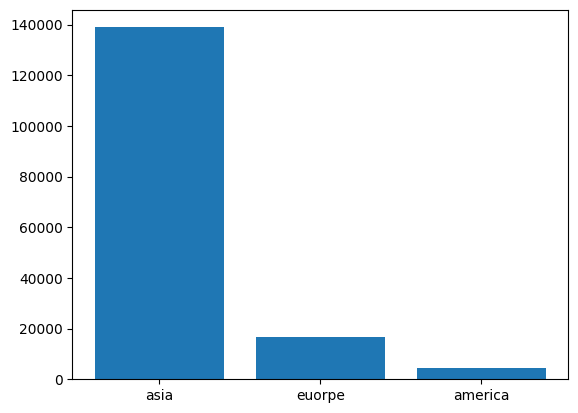

In [7]:
plt.bar(x=df['x24'].value_counts().index,height=df['x24'].value_counts().values)

In [8]:
df['x29'].value_counts()

July       45569
Jun        41329
Aug        29406
May        21939
sept.      10819
Apr         6761
Oct         2407
Mar         1231
Nov          337
Feb          140
Dev           23
January        9
Name: x29, dtype: int64

In [9]:
#clean up month formatting to standard 3 letters
df['x29'].replace(to_replace=['July','sept.','Dev','January'],value=['Jul','Sep','Dec','Jan'],inplace=True)

<BarContainer object of 12 artists>

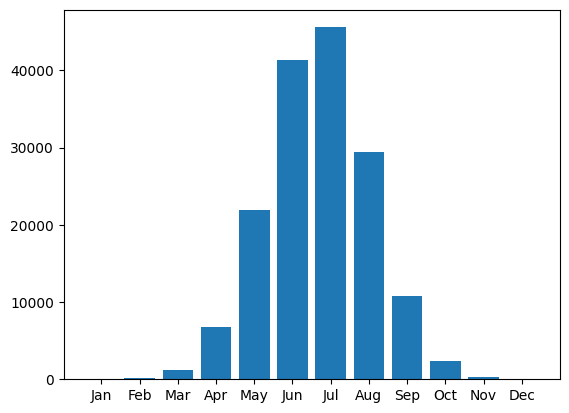

In [10]:
mo = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
heights = []
for i in mo:
    x = df['x29'].to_list().count(i)
    heights.append(x)
plt.bar(x=mo,height=heights)

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (25, 5))
plt.subplots_adjust(wspace=.18,hspace=1)
fig.subplots_adjust(top = .96)
sns.set(rc={'figure.figsize':(5.5,6)})
sns.countplot(x = 'x29', data = df, hue = 'y', ax = axes[0]);
sns.countplot(x = 'x30', data = df, hue = 'y', ax = axes[1]);
sns.countplot(x = 'x24', data = df, hue = 'y', ax = axes[2]);

fig.suptitle('Count plots for categorical features')

In [12]:
df['x30'].value_counts()

wednesday    101535
thurday       29429
tuesday       27954
friday          564
monday          488
Name: x30, dtype: int64

<BarContainer object of 5 artists>

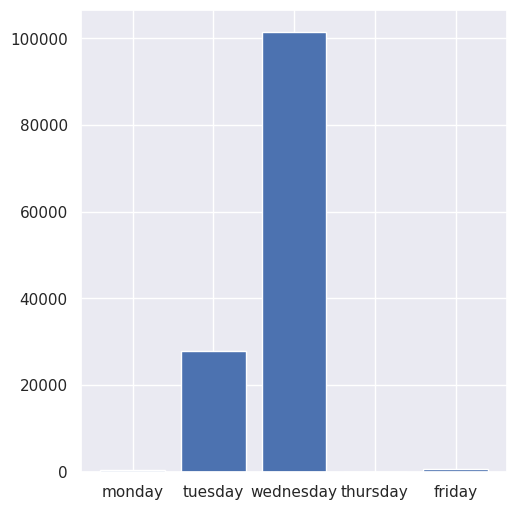

In [13]:
# thursday is incorrect
df['x30'].replace(to_replace = 'thurday',value='thursday')
days = ['monday','tuesday','wednesday','thursday','friday']
d_heights = []
for i in days:
    x = df['x30'].to_list().count(i)
    d_heights.append(x)
plt.bar(x=days,height = d_heights)

In [14]:
df['x32'].value_counts()

0.01%     40767
-0.01%    34094
0.0%      33923
-0.0%     30492
-0.02%     9924
0.02%      7987
-0.03%     1727
0.03%       855
-0.04%      138
0.04%        55
-0.05%        6
0.05%         1
Name: x32, dtype: int64

In [15]:
df['x37'].value_counts()


$-311.26     6
$-336.77     6
$237.4       6
$72.42       6
$341.26      6
            ..
$-505.21     1
$770.07      1
$74.62       1
$-1082.96    1
$-1229.34    1
Name: x37, Length: 129198, dtype: int64

In [16]:
### x32 and x37 are actually numeric with string format (even though x32 has few "levels" or possible values)
### x32 is in percentage, but don't think it needs to be transformed to proportion since data will be scaled later (will double check, but should make no difference)

df['x32'] = df['x32'].transform(lambda x: float(str(x).replace('%','')))
df['x37'] = df['x37'].transform(lambda x: float(str(x).replace('$','')))

In [17]:
#all significanlty less than 5%, should be no issue imputing,
#imputing categorical features with modes
# imputing continent with mode, then dates by mode grouped by continent

print('imputing continent with mode: {}'.format(df['x24'].aggregate(pd.Series.mode)))
df['x24'] = df['x24'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))

print('imputing month with mode by cont: {}'.format(df[['x24','x29']].groupby(by='x24').aggregate(pd.Series.mode)))
idx_29 = df.loc[df['x29'].isna(),:].index #saving NAs indices to quick check what they've been imputed with
df['x29'] = df[['x24','x29']].groupby(by='x24').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

# will fix index showing on print later


imputing continent with mode: 0    asia
Name: x24, dtype: object
imputing month with mode by cont:          x29
x24         
america  Jul
asia     Jul
euorpe   Jul


In [18]:
df[['x24','x29','x30']].groupby(by=['x24','x29']).aggregate(pd.Series.mode)
# could just impute with wednesday since Wed is mode per month, but adding continent gives more context and different days for some months

x30
x24     x29           
america Apr  wednesday
        Aug  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
asia    Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb  wednesday
        Jan  wednesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday
euorpe  Apr  wednesday
        Aug  wednesday
        Dec  wednesday
        Feb    tuesday
        Jul  wednesday
        Jun  wednesday
        Mar  wednesday
        May  wednesday
        Nov  wednesday
        Oct  wednesday
        Sep  wednesday

In [19]:
# impute day
df['x30'] = df[['x24','x29','x30']].groupby(by=['x24','x29']).transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

In [20]:
X = df.loc[:,df.columns != 'y']
y = df['y'].values.flatten()

df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 47 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      160000 non-null  float64
 1   x1      160000 non-null  float64
 2   x2      160000 non-null  float64
 3   x3      160000 non-null  float64
 4   x4      160000 non-null  float64
 5   x5      160000 non-null  float64
 6   x6      160000 non-null  float64
 7   x7      160000 non-null  float64
 8   x8      160000 non-null  float64
 9   x9      160000 non-null  float64
 10  x10     160000 non-null  float64
 11  x11     160000 non-null  float64
 12  x12     160000 non-null  float64
 13  x13     160000 non-null  float64
 14  x14     160000 non-null  float64
 15  x15     160000 non-null  float64
 16  x16     160000 non-null  float64
 17  x17     160000 non-null  float64
 18  x18     160000 non-null  float64
 19  x19     160000 non-null  float64
 20  x20     160000 non-null  float64
 21  x21     16

In [21]:
X = np.hstack([df_num,df_cat])

In [22]:
X.shape

(160000, 67)

In [23]:
df['y'].value_counts() # not balanced

0    95803
1    64197
Name: y, dtype: int64

In [24]:
## define cost function
def cost_func(y_pred,y_true):
    diff = y_pred - y_true
    x = 0
    for i in diff:
        #false pos (y_pred -y_true == 1)
        if i == 1:
            x += 100
        #false neg (y_pred -y_true ==-1)
        elif i == -1:
            x += 150
    return(x)

In [25]:
skf = StratifiedKFold(n_splits=5,random_state=807,shuffle=True)
skf.get_n_splits(X,y)

5

### Logistic Regression

In [26]:
#logR = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga')
#params = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,2,5,10],'l1_ratio':[0,0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1],'max_iter':[25,50,75]}

#lr_clf = GridSearchCV(estimator=logR,param_grid=params,n_jobs=-1,cv=skf)
#lr_clf.fit(X,y)

In [27]:
#lr_params = lr_clf.best_params_
lr_params ={'C': 0.001, 'l1_ratio': 0.5, 'max_iter': 50}

{'C': 0.001, 'l1_ratio': 0.5, 'max_iter': 50}

In [28]:
model1 = LogisticRegression(random_state=807,penalty='elasticnet',class_weight='balanced',solver='saga')
model1.set_params(**lr_params)
model1.fit(X,y)

preds_m1 = cross_val_predict(model1,X,y,cv=skf)

In [29]:
cr_m1 = classification_report(y,preds_m1,output_dict=True)
cr_m1

{'0': {'precision': 0.7707924178564336,
  'recall': 0.7292047221903281,
  'f1-score': 0.7494220567805746,
  'support': 95803},
 '1': {'precision': 0.6259983277109823,
  'recall': 0.6764023240961415,
  'f1-score': 0.6502249874591017,
  'support': 64197},
 'accuracy': 0.70801875,
 'macro avg': {'precision': 0.698395372783708,
  'recall': 0.7028035231432348,
  'f1-score': 0.6998235221198381,
  'support': 160000},
 'weighted avg': {'precision': 0.7126965040747615,
  'recall': 0.70801875,
  'f1-score': 0.7096210926603833,
  'support': 160000}}

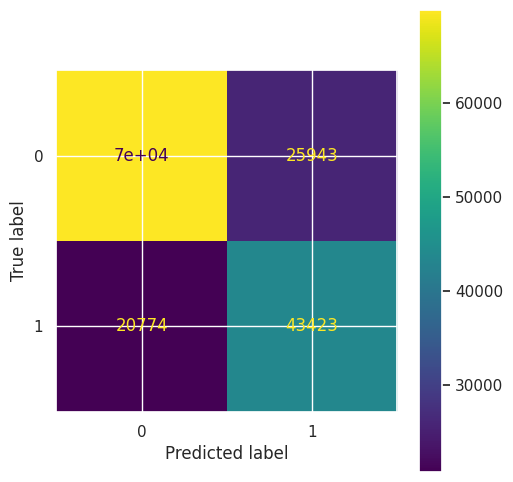

In [30]:
ConfusionMatrixDisplay.from_predictions(y,preds_m1)

In [31]:
cost_m1 = cost_func(preds_m1,y)
cost_m1

5710400

### Random Forest

In [32]:
rf = RandomForestClassifier(random_state=807,criterion='gini',class_weight='balanced')
params = {'n_estimators':[100, 200],'max_features':['sqrt','log2',20]}
rf_clf = GridSearchCV(rf,param_grid=params,cv=skf,n_jobs = -1)

In [33]:
rf_clf.fit(X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=807, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=807),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [100, 200]})

In [34]:
rf_clf.best_params_

{'max_features': 20, 'n_estimators': 200}

In [35]:
rf_params = rf_clf.best_params_
rf_params

{'max_features': 20, 'n_estimators': 200}

In [331]:
model2 = RandomForestClassifier(random_state=807,criterion='gini',class_weight='balanced')
model2.set_params(**rf_params)
preds_m2 = cross_val_predict(model2,X,y,cv=skf)

KeyboardInterrupt: ignored

In [ ]:
cr_m2 = classification_report(y,preds_m2,output_dict=True)
cr_m2

In [ ]:
ConfusionMatrixDisplay.from_predictions(y,preds_m2 ,cmap='Blues', colorbar=False)

In [ ]:
cost_m2 = cost_func(preds_m2,y)
cost_m2

### Neural Network

In [40]:
#sets binary values for predictions
def cost(y_true,y_pred):

  bin_p = K.switch(K.greater_equal(y_pred,0.5),K.constant(1,shape=y_pred.shape),
                   K.constant(0,shape=y_pred.shape))
  diff = bin_p-y_true

  error = K.switch(
      K.equal(diff,1),K.constant(100,shape=y_pred.shape),
      K.switch(
          K.equal(diff,-1),K.constant(150,shape=y_pred.shape),
          K.constant(0,shape=y_pred.shape)
      )
  )
  return(K.sum(error))

In [41]:
now = datetime.datetime.now

In [42]:
es = EarlyStopping(monitor='val_cost', mode='min',patience=10,restore_best_weights=True,start_from_epoch=40)
fold_results = {}
t_tot = now()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  model4 = tf.keras.Sequential()
  model4.add(tf.keras.Input(shape=(X.shape[1],)))
  model4.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model4.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))
  model4.add(tf.keras.layers.Dropout(0.4))
  model4.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model4.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False), 'accuracy',cost])
  t_fold = now()
  print('x_train shape:', X[train_index].shape)
  model4.fit(X[train_index],y[train_index],epochs=100,batch_size=64,validation_split=0.2,callbacks=[es])
  fold_results.update({i:{'predictions':model4.predict(X[test_index]).flatten(),'index':test_index,'y_true':y[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
print('total train/predict time: %s' % (now()-t_tot))

x_train shape: (128000, 67)
Epoch 1/100
1600/1600 [==============================] - 5s 2ms/step - loss: 0.3798 - auc: 0.9067 - accuracy: 0.8291 - cost: 1407.4375 - val_loss: 0.2844 - val_auc: 0.9492 - val_accuracy: 0.8822 - val_cost: 972.3750
Epoch 2/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2645 - auc: 0.9559 - accuracy: 0.8945 - cost: 855.6875 - val_loss: 0.2308 - val_auc: 0.9663 - val_accuracy: 0.9096 - val_cost: 724.0000
Epoch 3/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2252 - auc: 0.9679 - accuracy: 0.9131 - cost: 705.0938 - val_loss: 0.2000 - val_auc: 0.9746 - val_accuracy: 0.9252 - val_cost: 602.5000
Epoch 4/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1993 - auc: 0.9747 - accuracy: 0.9262 - cost: 598.9688 - val_loss: 0.1791 - val_auc: 0.9796 - val_accuracy: 0.9351 - val_cost: 519.3750
Epoch 5/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1825 - auc: 0.9785 - accuracy: 0

In [43]:
m4_results = fold_results

In [44]:
preds_m4 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    preds_m4[idx] = np.round(fold_results.get(i).get('predictions')[j],0)
m4_cost = cost_func(y,preds_m4)
m4_cost

651350

In [45]:
preds_new = np.zeros(len(y))
for i in m4_results.keys():
  for j in range(len(m4_results.get(i).get('predictions'))):
    idx = m4_results.get(i).get('index')[j]
    if m4_results.get(i).get('predictions')[j] > 0.6:
      preds_new[idx] = 1
    else:
      preds_new[idx] = 0
m4_cost_t = cost_func(y,preds_new)
m4_cost_t

635200

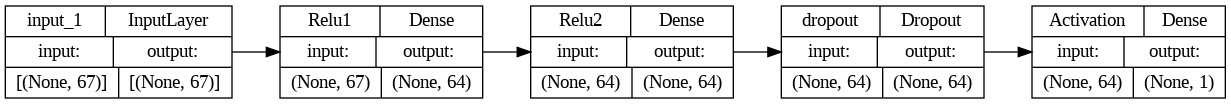

In [317]:
keras.utils.plot_model(model4, show_shapes=True, rankdir="LR")


In [319]:
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Relu1 (Dense)               (None, 64)                4352      
                                                                 
 Relu2 (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Activation (Dense)          (None, 1)                 65        
                                                                 
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [47]:
es = EarlyStopping(monitor='val_cost', mode='min',patience=15,restore_best_weights=True,start_from_epoch=40)
fold_results = {}
t_tot = now()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  # building model within loop to reset weights each time
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(807)
  #adamM5 = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model5 = tf.keras.Sequential()
  model5.add(tf.keras.Input(shape=(X.shape[1],)))
  model5.add(tf.keras.layers.Dense(64, activation='relu',name="Relu1"))
  model5.add(tf.keras.layers.Dense(64, activation='relu', name="Relu2"))
  #model5.add(tf.keras.layers.Dense(64, activation='relu', name="Relu3"))
  model5.add(tf.keras.layers.Dropout(0.4))
  model5.add(tf.keras.layers.Dense(1, activation='sigmoid', name="Activation"))
  model5.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics = [tf.keras.metrics.AUC(from_logits=False), 'accuracy',cost])
  t_fold = now()
  print('x_train shape:', X[train_index].shape)
  model5.fit(X[train_index],y[train_index],epochs=100,batch_size=64,validation_split=0.2,callbacks=[es])
  fold_results.update({i:{'predictions':model5.predict(X[test_index]).flatten(),'index':test_index,'y_true':y[test_index]}})
  print('fold train/predict time: %s' % (now()-t_fold))
print('total train/predict time: %s' % (now()-t_tot))

x_train shape: (128000, 67)
Epoch 1/100
1600/1600 [==============================] - 5s 2ms/step - loss: 0.3798 - auc: 0.9067 - accuracy: 0.8291 - cost: 1407.4375 - val_loss: 0.2844 - val_auc: 0.9492 - val_accuracy: 0.8822 - val_cost: 972.3750
Epoch 2/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2645 - auc: 0.9559 - accuracy: 0.8945 - cost: 855.6875 - val_loss: 0.2308 - val_auc: 0.9663 - val_accuracy: 0.9096 - val_cost: 724.0000
Epoch 3/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2252 - auc: 0.9679 - accuracy: 0.9131 - cost: 705.0938 - val_loss: 0.2000 - val_auc: 0.9746 - val_accuracy: 0.9252 - val_cost: 602.5000
Epoch 4/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1993 - auc: 0.9747 - accuracy: 0.9262 - cost: 598.9688 - val_loss: 0.1791 - val_auc: 0.9796 - val_accuracy: 0.9351 - val_cost: 519.3750
Epoch 5/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1825 - auc: 0.9785 - accuracy: 0

In [48]:
m5_results = fold_results

In [49]:
preds_m5 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    preds_m5[idx] = np.round(fold_results.get(i).get('predictions')[j],0)

m5_cost = cost_func(y,preds_m5)
m5_cost

644300

In [50]:
preds_new = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    if fold_results.get(i).get('predictions')[j] > 0.6:
      preds_new[idx] = 1
    else:
      preds_new[idx] = 0

m5_cost_t = cost_func(y,preds_new)
m5_cost_t

630150

In [51]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Relu1 (Dense)               (None, 64)                4352      
                                                                 
 Relu2 (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Activation (Dense)          (None, 1)                 65        
                                                                 
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


### XGBoost

In [52]:
#setting up a hyperparameter dataframe

learning_rates = [0.1, 0.25, 0.35]
max_depths = [3, 5, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

xgb_param = pd.DataFrame(list(product(learning_rates, max_depths, gamma, lambda_ls, alpha)), columns=['learning_rate', 'max_depth', 'gamma', 'lambda', 'alpha'])

#randomizing the dataframe order
xgb_param = shuffle(xgb_param)
xgb_param = xgb_param.reset_index()
xgb_param=xgb_param.drop(['index'], axis=1)
xgb_param

,learning_rate,max_depth,gamma,lambda,alpha
0,0.10,20,3,1,0.0
1,0.25,20,1,3,0.0
2,0.35,20,1,3,0.0
3,0.35,3,0,2,0.0
4,0.25,5,3,1,0.1
...,...,...,...,...,...
319,0.25,20,0,3,0.1
320,0.10,3,1,2,1.0
321,0.25,10,3,2,1.0
322,0.25,5,1,1,0.0


In [53]:
#setting up a hyperparameter dataframe

learning_rates = [0.1, 0.25]
max_depths = [3, 5, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

xgb_param = pd.DataFrame(list(product(learning_rates, max_depths, gamma, lambda_ls, alpha)), columns=['learning_rate', 'max_depth', 'gamma', 'lambda', 'alpha'])

#randomizing the dataframe order
xgb_param = shuffle(xgb_param)
xgb_param = xgb_param.reset_index()
xgb_param=xgb_param.drop(['index'], axis=1)
xgb_param

,learning_rate,max_depth,gamma,lambda,alpha
0,0.25,3,0,2,0.1
1,0.25,5,0,3,1.0
2,0.10,10,3,1,0.0
3,0.10,3,0,3,0.0
4,0.10,20,0,3,1.0
...,...,...,...,...,...
211,0.10,10,1,1,0.1
212,0.25,20,0,1,0.0
213,0.25,5,3,1,0.0
214,0.25,10,0,1,1.0


In [54]:
dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
dtest = xgb.DMatrix(X[test_index], label=y[test_index])

trials = 30
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf
  hyperparams = {'objective': 'binary:logistic',
                 'eta': xgb_param['learning_rate'][i],
                 'max_depth': xgb_param['max_depth'][i],
                 'gamma': xgb_param['gamma'][i],
                 'lambda': xgb_param['lambda'][i],
                 'alpha': xgb_param['alpha'][i],
                 'eval_metric': 'aucpr'
                 }

  print(hyperparams)
  out=xgb.cv(params=hyperparams,
             num_boost_round=20,
             dtrain=dtrain,
             nfold=5,
             stratified=True,
             early_stopping_rounds=3,
             verbose_eval=1
             )

  index=out.shape[0]-1
  result=out.iloc[index,2]
  if i< 1.1:
    best_result = result
    best_params = hyperparams

  if result> best_result:
      best_result = result
      best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,best_params)
      i+=1

{'objective': 'binary:logistic', 'eta': 0.25, 'max_depth': 3, 'gamma': 0, 'lambda': 2, 'alpha': 0.1, 'eval_metric': 'aucpr'}
[0]	train-aucpr:0.64563+0.00181	test-aucpr:0.64315+0.00505
[1]	train-aucpr:0.69980+0.00174	test-aucpr:0.69633+0.00534
[2]	train-aucpr:0.72409+0.00755	test-aucpr:0.71974+0.01007
[3]	train-aucpr:0.73761+0.00208	test-aucpr:0.73401+0.00555
[4]	train-aucpr:0.74850+0.00132	test-aucpr:0.74449+0.00515
[5]	train-aucpr:0.75308+0.00284	test-aucpr:0.74841+0.00202
[6]	train-aucpr:0.76401+0.00358	test-aucpr:0.75897+0.00562
[7]	train-aucpr:0.77443+0.00387	test-aucpr:0.76929+0.00501
[8]	train-aucpr:0.78353+0.00227	test-aucpr:0.77830+0.00214
[9]	train-aucpr:0.79100+0.00270	test-aucpr:0.78574+0.00044
[10]	train-aucpr:0.79796+0.00160	test-aucpr:0.79272+0.00191
[11]	train-aucpr:0.80414+0.00166	test-aucpr:0.79894+0.00328
[12]	train-aucpr:0.80805+0.00231	test-aucpr:0.80253+0.00271
[13]	train-aucpr:0.81465+0.00377	test-aucpr:0.80908+0.00378
[14]	train-aucpr:0.81993+0.00351	test-aucpr:0

In [55]:
best_params

{'objective': 'binary:logistic',
 'eta': 0.25,
 'max_depth': 20,
 'gamma': 1,
 'lambda': 1,
 'alpha': 1.0,
 'eval_metric': 'aucpr'}

In [59]:
aucpr_params = {'objective': 'binary:logistic',
         'eta': 0.25,
         'max_depth': 20,
         'gamma': 1,
         'lambda': 1,
         'alpha': 1.0,
         'eval_metric': 'aucpr'}

In [60]:
fold_results = {}

for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    dtest = xgb.DMatrix(X[test_index], label=y[test_index])
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    tr=xgb.train(params=aucpr_params,
                 num_boost_round=222,
                 dtrain=dtrain,
                 verbose_eval=1,
                 evals=evallist,
                 early_stopping_rounds = 3
             )

    preds_XGB = np.round(tr.predict(dtest), 0)

    classification_report(y[test_index],np.round(preds_XGB, 0),output_dict=True)
    fold_results.update({i:{'predictions':preds_XGB,'index':test_index,'y_true':y[test_index]}})

[0]	train-aucpr:0.95637	eval-aucpr:0.88765
[1]	train-aucpr:0.98006	eval-aucpr:0.92214
[2]	train-aucpr:0.98894	eval-aucpr:0.93891
[3]	train-aucpr:0.99180	eval-aucpr:0.94592
[4]	train-aucpr:0.99410	eval-aucpr:0.95182
[5]	train-aucpr:0.99541	eval-aucpr:0.95523
[6]	train-aucpr:0.99629	eval-aucpr:0.95760
[7]	train-aucpr:0.99683	eval-aucpr:0.95925
[8]	train-aucpr:0.99741	eval-aucpr:0.96116
[9]	train-aucpr:0.99792	eval-aucpr:0.96266
[10]	train-aucpr:0.99828	eval-aucpr:0.96439
[11]	train-aucpr:0.99858	eval-aucpr:0.96591
[12]	train-aucpr:0.99881	eval-aucpr:0.96730
[13]	train-aucpr:0.99902	eval-aucpr:0.96824
[14]	train-aucpr:0.99916	eval-aucpr:0.96904
[15]	train-aucpr:0.99928	eval-aucpr:0.96988
[16]	train-aucpr:0.99937	eval-aucpr:0.97065
[17]	train-aucpr:0.99945	eval-aucpr:0.97132
[18]	train-aucpr:0.99952	eval-aucpr:0.97186
[19]	train-aucpr:0.99957	eval-aucpr:0.97254
[20]	train-aucpr:0.99960	eval-aucpr:0.97293
[21]	train-aucpr:0.99966	eval-aucpr:0.97307
[22]	train-aucpr:0.99970	eval-aucpr:0.9734

In [61]:
preds_m6 = np.zeros(len(y))
for i in fold_results.keys():
  for j in range(len(fold_results.get(i).get('predictions'))):
    idx = fold_results.get(i).get('index')[j]
    preds_m6[idx] = np.round(fold_results.get(i).get('predictions')[j], 0)

In [75]:
m6_cost = cost_func(preds_m6,y)
m6_cost

1203450

### Results

In [89]:
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels):
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

In [66]:
cm_preds_m1 = confusion_matrix(y,preds_m1)
cm_preds_m2 = confusion_matrix(y,preds_m2)
cm_preds_m4 = confusion_matrix(y,preds_m4)
cm_preds_m5 = confusion_matrix(y,preds_m5)
cm_preds_m6 = confusion_matrix(y,preds_m6)


cm_preds_m1 = cm_preds_m1 / cm_preds_m1.astype(np.float).sum(axis=1)
cm_preds_m2 = cm_preds_m2 / cm_preds_m2.astype(np.float).sum(axis=1)
cm_preds_m4 = cm_preds_m4 / cm_preds_m4.astype(np.float).sum(axis=1)
cm_preds_m5 = cm_preds_m5 / cm_preds_m5.astype(np.float).sum(axis=1)
cm_preds_m6 = cm_preds_m6 / cm_preds_m6.astype(np.float).sum(axis=1)

In [287]:
Pos = pd.DataFrame(cm_preds_m1[:1], columns=['True Positive', 'False Positive'])
Neg = pd.DataFrame(cm_preds_m1[1:], columns=['False Negative', 'True Negative'])
Model = pd.DataFrame(['Logistic Regression'], columns=['Model'])
Summary = pd.concat([Model, Pos, Neg], axis=1)

Pos = pd.DataFrame(cm_preds_m2[:1], columns=['True Positive', 'False Positive'])
Neg = pd.DataFrame(cm_preds_m2[1:], columns=['False Negative', 'True Negative'])
Model = pd.DataFrame(['Random Forest'], columns=['Model'])
Summary1 = (pd.concat([Model, Pos, Neg], axis=1))

Summary = pd.concat([Summary, Summary1])

Pos = pd.DataFrame(cm_preds_m4[:1], columns=['True Positive', 'False Positive'])
Neg = pd.DataFrame(cm_preds_m4[1:], columns=['False Negative', 'True Negative'])
Model = pd.DataFrame(['Neural Network'], columns=['Model'])
Summary1 = (pd.concat([Model, Pos, Neg], axis=1))

Summary = pd.concat([Summary, Summary1])

Pos = pd.DataFrame(cm_preds_m5[:1], columns=['True Positive', 'False Positive'])
Neg = pd.DataFrame(cm_preds_m5[1:], columns=['False Negative', 'True Negative'])
Model = pd.DataFrame(['Neural Network 2'], columns=['Model'])
Summary1 = (pd.concat([Model, Pos, Neg], axis=1))

Summary = pd.concat([Summary, Summary1])

Pos = pd.DataFrame(cm_preds_m6[:1], columns=['True Positive', 'False Positive'])
Neg = pd.DataFrame(cm_preds_m6[1:], columns=['False Negative', 'True Negative'])
Model = pd.DataFrame(['XGBoost'], columns=['Model'])
Summary1 = (pd.concat([Model, Pos, Neg], axis=1))

Summary = pd.concat([Summary, Summary1])
Summary = Summary.reset_index()
Summary = Summary.drop(columns=['index'])
Summary = Summary.set_index('Model')

Summary = Summary[['True Positive', 'True Negative', 'False Positive', 'False Negative']]


Summary

,True Positive,True Negative,False Positive,False Negative
Model,,,,
Logistic Regression,50%,85%,51%,15%
Random Forest,94%,91%,6%,9%
Neural Network,96%,97%,4%,3%
Neural Network 2,96%,97%,4%,3%
XGBoost,94%,94%,6%,5%


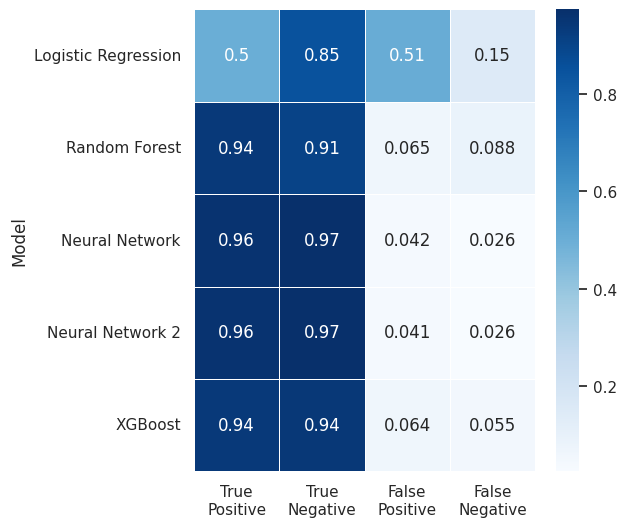

In [297]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

ax = sns.heatmap(Summary, cmap='Blues', linewidths=0.50, annot=True)
wrap_labels(ax, 10)

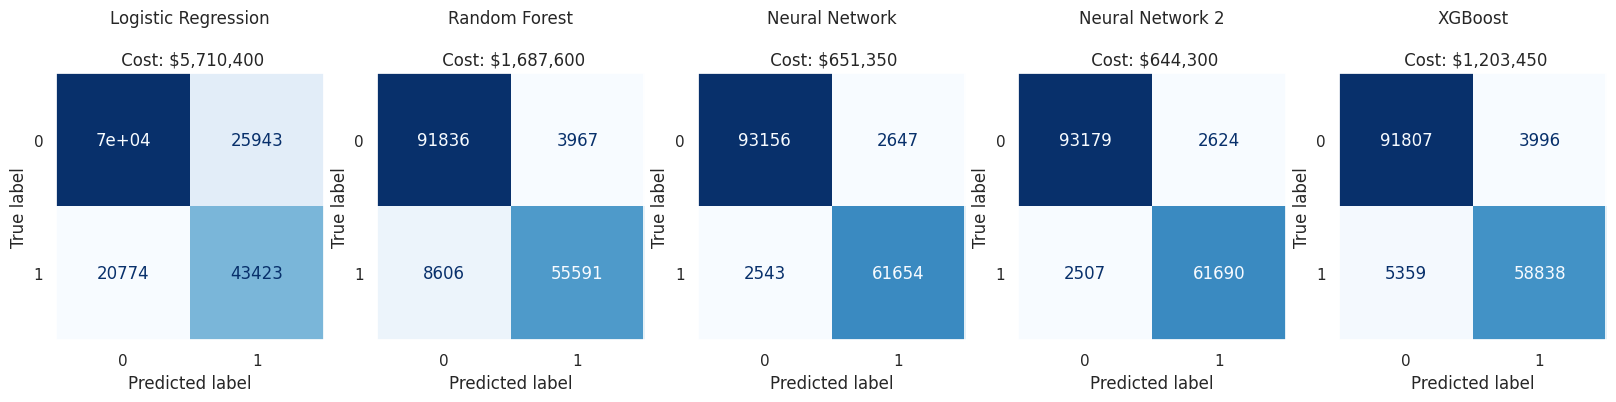

In [82]:
#Confusion Matrix of Results

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt


cm_preds_m1 = confusion_matrix(y,preds_m1)
cm_preds_m2 = confusion_matrix(y,preds_m2)
cm_preds_m4 = confusion_matrix(y,preds_m4)
cm_preds_m5 = confusion_matrix(y,preds_m5)
cm_preds_m6 = confusion_matrix(y,preds_m6)

fig, ax = plt.subplots(1,5,figsize= (20,4))

disp1 = ConfusionMatrixDisplay(cm_preds_m1).plot(ax = ax[0],cmap = 'Blues', colorbar=False)
ax[0].set_title('Logistic Regression'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_m1:,}'), fontsize = 12)
ax[0].grid(False)

disp2 = ConfusionMatrixDisplay(cm_preds_m2).plot(ax= ax[1],cmap='Blues', colorbar=False)
ax[1].set_title('Random Forest'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_m2:,}'), fontsize = 12)
ax[1].grid(False)


disp3 = ConfusionMatrixDisplay(cm_preds_m4).plot(ax= ax[2],cmap='Blues', colorbar=False)
ax[2].set_title('Neural Network'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m4_cost:,}'), fontsize = 12)
ax[2].grid(False)

disp4 = ConfusionMatrixDisplay(cm_preds_m5).plot(ax= ax[3],cmap='Blues', colorbar=False)
ax[3].set_title('Neural Network 2'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m5_cost:,}'), fontsize = 12)
ax[3].grid(False)

disp5 = ConfusionMatrixDisplay(cm_preds_m6).plot(ax= ax[4],cmap='Blues', colorbar=False)
ax[4].set_title('XGBoost'+ '\n\n' + ' Cost: '+ '$'+ str(f'{m6_cost:,}'), fontsize = 12)
ax[4].grid(False)


plt.show()

### Ensembling

In [381]:
#Combination of Neural Networks
preds_nn = (preds_m4+ preds_m5)/2
cost_nn= cost_func(np.round(preds_nn, 0), y)
cm_preds_nn = confusion_matrix(y,np.round(preds_nn, 0))

#Combination of Neural Networks and XGBoost
preds_ens = (preds_m4+ preds_m5+preds_m6)/3
cost_ens = cost_func(np.round(preds_ens, 0), y)
cm_preds_ens = confusion_matrix(y,preds_m1)

#Combination of Neural Networks, XGBoost, and RF
preds_ens2 = (preds_m2 + preds_m4+ preds_m5+preds_m6)/4
cost_ens2 = cost_func(np.round(preds_ens2, 0), y)
cm_preds_ens2= confusion_matrix(y,np.round(preds_ens2, 0))

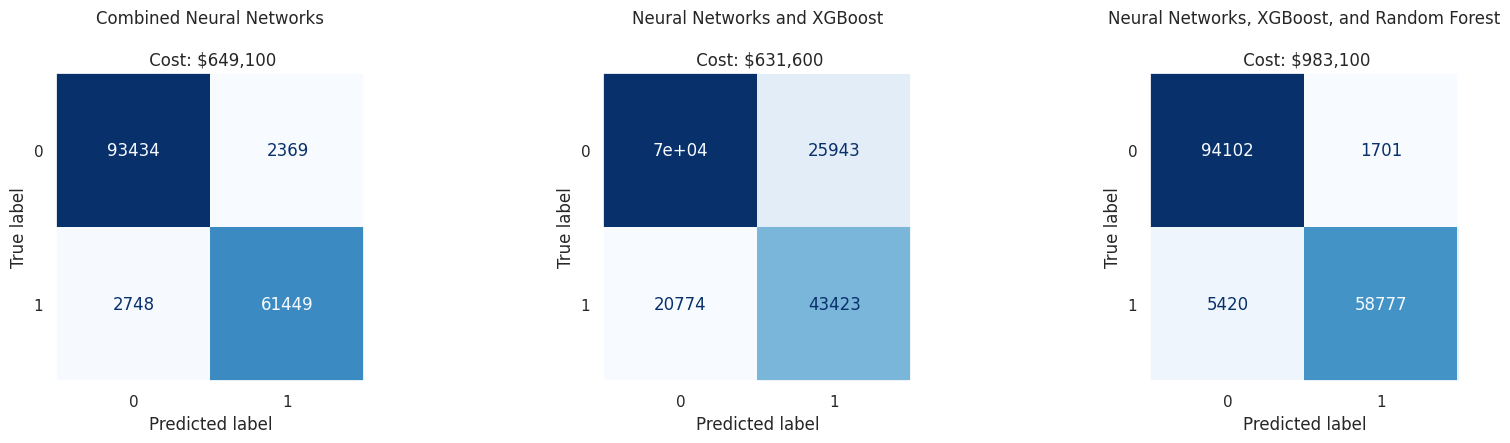

In [383]:
fig, ax = plt.subplots(1,3,figsize= (20,4))

disp1 = ConfusionMatrixDisplay(cm_preds_nn).plot(ax = ax[0],cmap = 'Blues', colorbar=False)
ax[0].set_title('Combined Neural Networks'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_nn:,}'), fontsize = 12)
ax[0].grid(False)

disp1 = ConfusionMatrixDisplay(cm_preds_ens).plot(ax = ax[1],cmap = 'Blues', colorbar=False)
ax[1].set_title('Neural Networks and XGBoost'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_ens:,}'), fontsize = 12)
ax[1].grid(False)

disp1 = ConfusionMatrixDisplay(cm_preds_ens2).plot(ax = ax[2],cmap = 'Blues', colorbar=False)
ax[2].set_title('Neural Networks, XGBoost, and Random Forest'+ '\n\n' + ' Cost: '+ '$'+ str(f'{cost_ens2:,}'), fontsize = 12)
ax[2].grid(False)

